# Dataset 1 

In [41]:
import numpy as np
import pandas as pd
import re
import itertools
import nltk
import seaborn as sb
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import nltk
import stopwordsiso as tagalogStopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from sklearn import svm
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import GridSearchCV

## Exploring the Dataset

In [2]:
# loading the dataset to a pandas dataframe
news_dataset = pd.read_csv('Documents/COLLEGE/THESIS/DATASET/PH_dataset1.csv')

In [3]:
# number of (rows, columns) = (news articles, features)
news_dataset.shape

(3206, 2)

In [4]:
# print the first 5 rows of the dataframe
news_dataset.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


### <font color=skyblue> Word Cloud

In [5]:
# Function to generate wordclouds (with Tagalog stopwords)
def generate_wordcloud(data, label, title):
    text = " ".join(text for text in data[data['label'] == label]['article'])

    # Combine default English stopwords with Tagalog stopwords
    stopwords = set(STOPWORDS)
    stopwords.update(tagalogStopwords.stopwords(["tl"]))

    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=800, height=400
    ).generate(text)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

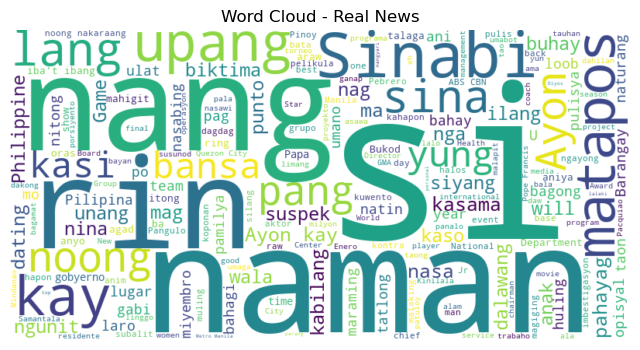

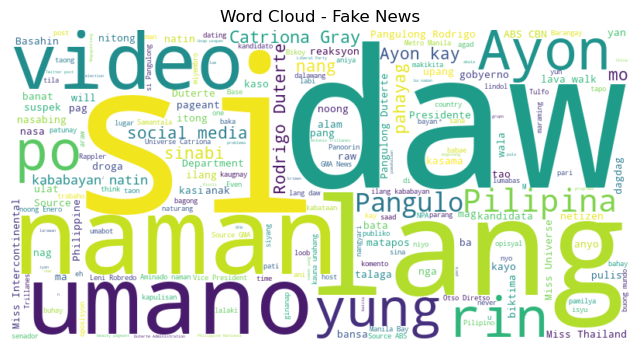

In [6]:
# Generate word clouds for each label
generate_wordcloud(news_dataset, 0, "Word Cloud - Real News")
generate_wordcloud(news_dataset, 1, "Word Cloud - Fake News")

## Initializing Dataset

In [7]:
# replacing values in the 'label' column
news_dataset['label'] = news_dataset['label'].replace({'REAL': 0, 'FAKE': 1})

In [8]:
news_dataset.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


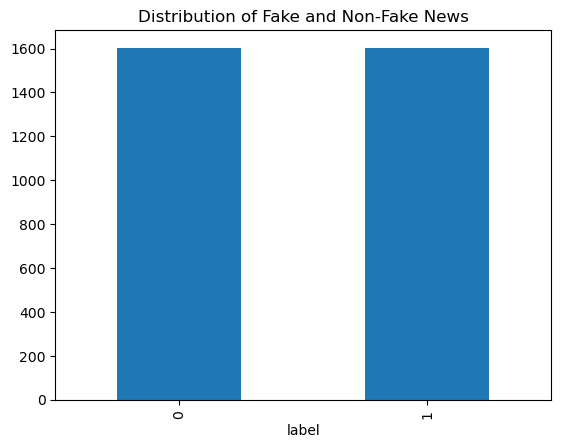

In [9]:
news_dataset['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Fake and Non-Fake News')
plt.show()

## Data Cleaning

### <font color=orange> Handling Missing Values

In [10]:
# counting the number of missing values in the dataset
news_dataset.isnull().sum()

label      0
article    0
dtype: int64

In [11]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

### <font color=orange>Removing Duplicate Entries

In [12]:
#checking for duplicated values
news_dataset.duplicated(['label', 'article'])

0       False
1       False
2       False
3       False
4       False
        ...  
3201    False
3202    False
3203    False
3204    False
3205    False
Length: 3206, dtype: bool

### <font color=orange> Merging Columns

In [13]:
# renaming the article column
news_dataset['content'] = news_dataset['article']

In [14]:
# dropping the article column
news_dataset.drop(columns=['article'], inplace=True)

In [15]:
news_dataset.head()

,label,content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


## Text Normalization

### <font color=orange> Separating Columns

In [16]:
# separating the content & label
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [17]:
print(X)
print(Y)

                                                content
0     Ayon sa TheWrap.com, naghain ng kaso si Krupa,...
1     Kilala rin ang singer sa pagkumpas ng kanyang ...
2     BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...
3     Kasama sa programa ang pananalangin, bulaklak ...
4     Linisin ang Friendship Department dahil dadala...
...                                                 ...
3201  Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202  Sa isang pahayag, binatikos ng Liberal Party (...
3203  Panoorin nyo yung reaction video na ito ni Mr....
3204  Para sa mga magkakapatid na laging nagtatalo l...
3205  Grabe ibang klase talaga si Vice Ganda kung ma...

[3206 rows x 1 columns]
0       0
1       0
2       0
3       0
4       0
       ..
3201    1
3202    1
3203    1
3204    1
3205    1
Name: label, Length: 3206, dtype: int64


### <font color=orange> Data Preprocessing

In [18]:
def filtering(content):  
    filtered_content = re.sub('[^a-zA-Z]', ' ', content)  # Remove non-alphabetic characters
    filtered_content = filtered_content.lower()  # Lowercase
    filtered_content = filtered_content.split()  # Tokenize
    filtered_content = [word for word in filtered_content if not word in tagalogStopwords.stopwords('tl')]  # Remove Tagalog stopwords
    filtered_content = ' '.join(filtered_content)  # Join back into a string
    return filtered_content

In [19]:
news_dataset['content'] = news_dataset['content'].apply(filtering) #filtering

In [20]:
print(news_dataset['content'])

0       ayon thewrap com naghain kaso si krupa noong h...
1       kilala rin singer pagkumpas kamay tuwing nagta...
2       blantyre malawi ap bumiyahe patungong malawi s...
3       kasama programa pananalangin bulaklak pagsindi...
4       linisin friendship department dadalawin angel ...
                              ...                        
3201    nai enjoy giacomo filibeck pilipinas agad iton...
3202    pahayag binatikos liberal party lp pagkuwestiy...
3203    panoorin nyo yung reaction video mr claro the ...
3204    magkakapatid laging nagtatalo lalo noong bata ...
3205    grabe ibang klase talaga si vice ganda magpata...
Name: content, Length: 3206, dtype: object


## Separating the data and label

In [21]:
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [22]:
print(X)

['ayon thewrap com naghain kaso si krupa noong huwebes nakaranas umano emotional distress bunga malisyosong pahayag glanville maselang bahagi katawan kundi pati rin buhay pag noong nobyembre napanood si brandi watch what happens live sinabing kinausap umano dating karelasyon joanna si mohamed hadid kasal cast member real housewives of beverly hills si yolanda foster nasa relasyon nagsabing p sy smelled classy rin naman pagkakabanggit brandi noong disyembre panibagong komento si glanville pagharap youtube sinabing you can t help the odor situation makalipas ilang linggo nagpadala sulat abogado krupa kay brandi planong pagsampa kaso nakalakip sulat abogado joanna you knew your statements were false and that such were damaging and humiliating to mrs krupa and or her husband and subjected mrs krupa to hatred ridicule contempt and or injury moreover it appears you make false statements about mrs krupa to make yourself marketable and to associate your name with a celebrity in attempt to tag 

In [23]:
print(Y)

[0 0 0 ... 1 1 1]


In [24]:
Y.shape

(3206,)

In [25]:
#def create_distribution(dataFile):
    #return sb.countplot(x='label', data=dataFile, palette='hls')
#create_distribution(news_dataset)

### <font color=orange> TF-IDF Vectorizer

In [26]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [27]:
print(X)

  (0, 37677)	0.05203180324257585
  (0, 37672)	0.18106578667404738
  (0, 37670)	0.11489367454324179
  (0, 37667)	0.09096719586544626
  (0, 37658)	0.0561153590448073
  (0, 37423)	0.061030504681737714
  (0, 37301)	0.03798412897099484
  (0, 37285)	0.08559317396570659
  (0, 37189)	0.050507274027408046
  (0, 36271)	0.06990905685740588
  (0, 35406)	0.1185936393599957
  (0, 34981)	0.07860911660025516
  (0, 34959)	0.01766530342404643
  (0, 34957)	0.024252736546058876
  (0, 34316)	0.06449992980986129
  (0, 34216)	0.06351158226941248
  (0, 33814)	0.18540387607066472
  (0, 33750)	0.050049591768984415
  (0, 33707)	0.07210696247925295
  (0, 33524)	0.06180129202355491
  (0, 33512)	0.17912419780414995
  (0, 33102)	0.07860911660025516
  (0, 32994)	0.05491620205957201
  (0, 32707)	0.08731956362234673
  (0, 32546)	0.07116077341624549
  :	:
  (3205, 29337)	0.21647986219604923
  (3205, 27465)	0.0956458122557635
  (3205, 25037)	0.07566268602411018
  (3205, 24952)	0.18411712156616106
  (3205, 24809)	0.132814

### Splitting the Dataset

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

### <font color=pink> Scores Function </font>

In [29]:
def scores(model, X_train, Y_train, X_test, Y_test):
    # Training Set Metrics
    X_train_prediction = model.predict(X_train)
    cm_train = metrics.confusion_matrix(Y_train, X_train_prediction)
    recall_train = metrics.recall_score(Y_train, X_train_prediction)
    f1_train = metrics.f1_score(Y_train, X_train_prediction)
    accuracy_train = metrics.accuracy_score(Y_train, X_train_prediction)   

    # Testing Set Metrics
    X_test_prediction = model.predict(X_test)
    cm_test = metrics.confusion_matrix(Y_test, X_test_prediction)
    recall_test = metrics.recall_score(Y_test, X_test_prediction)
    f1_test = metrics.f1_score(Y_test, X_test_prediction)
    accuracy_test = metrics.accuracy_score(Y_test, X_test_prediction)  

    # Return results in a dictionary
    return {
        'Training Set': {
            'Accuracy': accuracy_train, 
            'Confusion Matrix': cm_train,
            'Recall': recall_train,
            'F1-Score': f1_train,
        },
        'Testing Set': {
            'Accuracy': accuracy_test,  
            'Confusion Matrix': cm_test,
            'Recall': recall_test,
            'F1-Score': f1_test,
        }
    }
def print_scores_table(scores_dict):
    print('Evaluation Metrics:')
    for dataset, metrics in scores_dict.items():
        print(f"\n{dataset}:")
        print("Accuracy:", metrics['Accuracy']) 
        print("Confusion Matrix:\n", metrics['Confusion Matrix'])
        print("Recall:", metrics['Recall'])
        print("F1-Score:", metrics['F1-Score'])

### <font color=pink> Confusion Matrix Plot Function </font>

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Training the Models

## <font color=violet> Logistic Regression</font>

In [31]:
LR_model = LogisticRegression()

In [32]:
LR_model = LR_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [33]:
LR_evaluation_scores = scores(LR_model, X_train, Y_train, X_test, Y_test)
print_scores_table(LR_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9750390015600624
Confusion Matrix:
 [[1273    9]
 [  55 1227]]
Recall: 0.9570982839313572
F1-Score: 0.9745830023828435

Testing Set:
Accuracy: 0.9236760124610592
Confusion Matrix:
 [[312   9]
 [ 40 281]]
Recall: 0.8753894080996885
F1-Score: 0.9198036006546645


Accuracy: 92.37%
Confusion matrix, without normalization


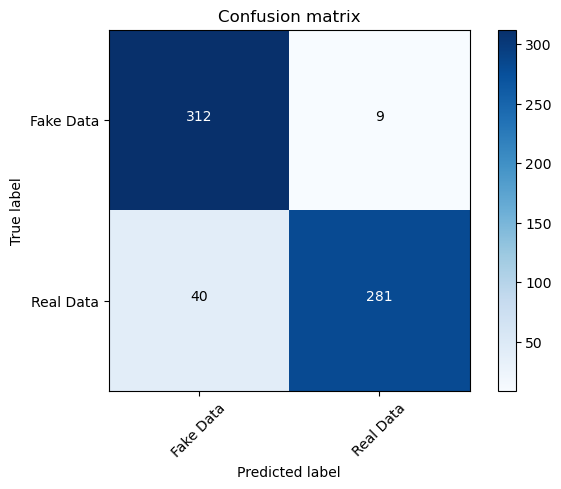

In [34]:
#accuracy score on the test data
Y_pred = LR_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [35]:
X_new_LR = X_test[2]

prediction_LR = LR_model.predict(X_new_LR)
print(prediction_LR)

if (prediction_LR[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


### <font color=violet> K-Nearest Neighbors Classifier</font>

In [36]:
KNN_model = KNeighborsClassifier()

In [37]:
KNN_model = KNN_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [38]:
KNN_evaluation_scores = scores(KNN_model, X_train, Y_train, X_test, Y_test)
print_scores_table(KNN_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9208268330733229
Confusion Matrix:
 [[1128  154]
 [  49 1233]]
Recall: 0.9617784711388455
F1-Score: 0.92394155114275

Testing Set:
Accuracy: 0.8598130841121495
Confusion Matrix:
 [[248  73]
 [ 17 304]]
Recall: 0.9470404984423676
F1-Score: 0.8710601719197708


Accuracy: 85.98%
Confusion matrix, without normalization


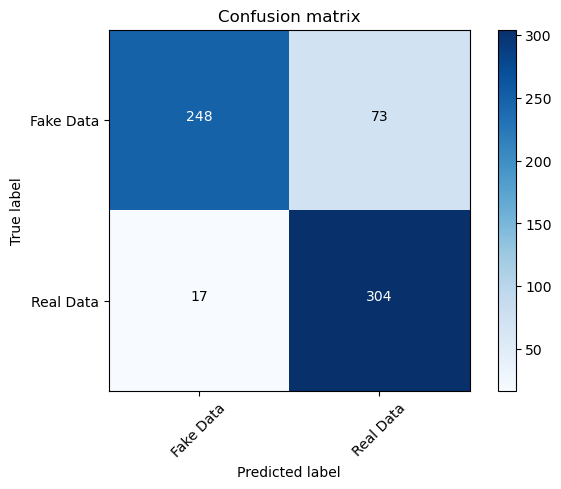

In [39]:
#accuracy score on the test data
Y_pred = KNN_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [40]:
X_new_KNN = X_test[3]

prediction_KNN = KNN_model.predict(X_new_KNN)
print(prediction_KNN)

if (prediction_KNN[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


### <font color=violet> Support Vector Machine </font>

In [50]:
# Lowering C for regularization
SVM_model = svm.SVC(probability=True, C=0.1, kernel='linear')  

In [51]:
SVM_model = SVM_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [52]:
SVM_evaluation_scores = scores(SVM_model, X_train, Y_train, X_test, Y_test)
print_scores_table(SVM_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9028861154446178
Confusion Matrix:
 [[1267   15]
 [ 234 1048]]
Recall: 0.8174726989079563
F1-Score: 0.8938166311300639

Testing Set:
Accuracy: 0.8769470404984424
Confusion Matrix:
 [[317   4]
 [ 75 246]]
Recall: 0.7663551401869159
F1-Score: 0.8616462346760071


Accuracy: 87.69%
Confusion matrix, without normalization


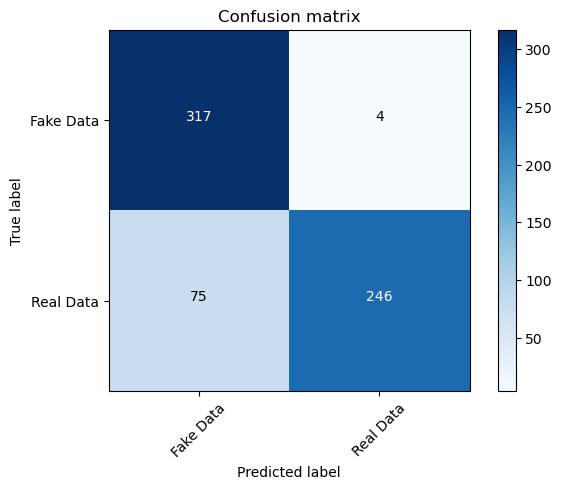

In [53]:
#accuracy score on the test data
Y_pred = SVM_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [54]:
X_new_SVM = X_test[2]

prediction_SVM = SVM_model.predict(X_new_SVM)
print(prediction_SVM)

if (prediction_SVM[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


### <font color=violet> Decision Tree</font>

In [55]:
# applying Pre-Pruning techniques to control tree complexity during the growth phase
DT_model = tree.DecisionTreeClassifier(           
      max_depth=3,          # limiting the depth of the tree
      min_samples_split=5,  # minimum samples to create a split
      min_samples_leaf=2    # minimum samples in a leaf node 
)

In [56]:
DT_model = DT_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [57]:
DT_evaluation_scores = scores(DT_model, X_train, Y_train, X_test, Y_test)
print_scores_table(DT_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9009360374414976
Confusion Matrix:
 [[1185   97]
 [ 157 1125]]
Recall: 0.8775351014040562
F1-Score: 0.8985623003194889

Testing Set:
Accuracy: 0.897196261682243
Confusion Matrix:
 [[296  25]
 [ 41 280]]
Recall: 0.8722741433021807
F1-Score: 0.8945686900958467


Accuracy: 89.72%
Confusion matrix, without normalization


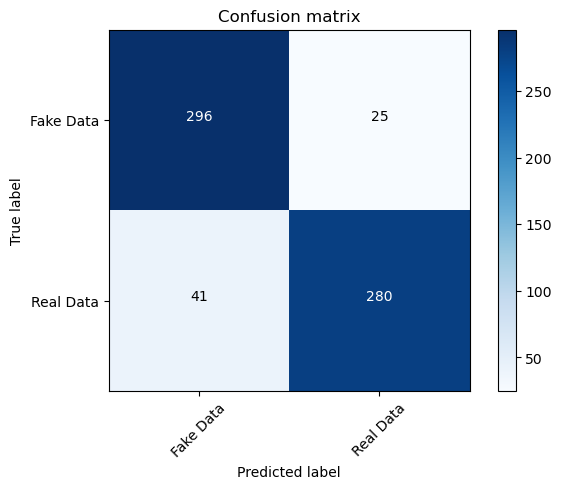

In [58]:
#accuracy score on the test data
Y_pred = DT_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [59]:
X_new_DT = X_test[3]
prediction_DT = DT_model.predict(X_new_DT)
print(prediction_DT)

if (prediction_DT[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


### <font color=violet> Multinomial Naive Bayes</font>

In [60]:
MNB_model = MultinomialNB() 

In [61]:
MNB_model = MNB_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [62]:
MNB_evaluation_scores = scores(MNB_model, X_train, Y_train, X_test, Y_test)
print_scores_table(MNB_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9645085803432137
Confusion Matrix:
 [[1196   86]
 [   5 1277]]
Recall: 0.9960998439937597
F1-Score: 0.9655954631379962

Testing Set:
Accuracy: 0.8691588785046729
Confusion Matrix:
 [[251  70]
 [ 14 307]]
Recall: 0.956386292834891
F1-Score: 0.8796561604584527


Accuracy: 86.92%
Confusion matrix, without normalization


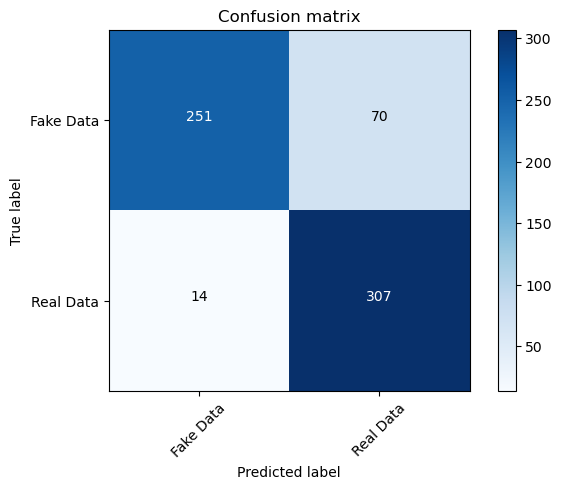

In [63]:
#accuracy score on the test data
Y_pred = MNB_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [64]:
X_new_MNB = X_test[3]

prediction_MNB = LR_model.predict(X_new_MNB)
print(prediction_MNB)

if (prediction_MNB[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real
